# Загрузка изображений

До сих пор мы работали с довольно искусственными наборами данных, которые обычно не используются в реальных проектах. Вместо этого вам, вероятно, придется иметь дело с полноразмерными изображениями, такими как те, что вы получаете от камер смартфонов. В этом блокноте мы рассмотрим, как загружать изображения и использовать их для обучения нейронных сетей.

Мы будем использовать [набор данных с фотографиями кошек и собак](https://www.kaggle.com/c/dogs-vs-cats), доступный на Kaggle. Вот несколько примеров изображений:

<img src='assets/dog_cat.png'>

Мы используем этот набор данных для обучения нейронной сети, которая сможет различать кошек и собак. В наши дни это не кажется большим достижением, но некоторое время назад это было серьезной задачей для систем компьютерного зрения.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper

c:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Самый простой способ загрузить изображения - это использовать `datasets.ImageFolder` из `torchvision` ([документация](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)). В общем случае, вы будете использовать `ImageFolder` следующим образом:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

где `'path/to/data'` - это путь к каталогу с данными, а `transform` - это последовательность операций обработки, созданная с помощью модуля [`transforms`](https://pytorch.org/vision/0.9/transforms.html) из `torchvision`. ImageFolder ожидает, что файлы и папки будут структурированы следующим образом:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

где каждому классу соответствует своя папка (`cat` и `dog`) для изображений. Изображения затем маркируются классом, взятым из названия папки. Таким образом, изображение `123.png` будет загружаться с меткой класса `cat`. Вы можете скачать уже структурированный набор данных [отсюда](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). Набор разделен на обучающую и тестовую выборки.

### Преобразования (transforms)

Когда вы загружаете данные с помощью `ImageFolder`, вам нужно будет определить некоторые преобразования. Например, изображения имеют разные размеры, но нам нужно, чтобы все они были одного размера для обучения. Вы можете либо изменить их размер с помощью `transforms.Resize()`, либо обрезать с помощью `transforms.CenterCrop()`, `transforms.RandomResizedCrop()` и т. д. Также нам нужно будет преобразовать изображения в тензоры PyTorch с помощью `transforms.ToTensor()`. Обычно необходимо комбинировать эти преобразования в конвейер с использованием `transforms.Compose()`, который принимает список преобразований и выполняет их последовательно. Это выглядит примерно так (изменяем размер, затем обрезаем, а затем преобразовываем в тензор):

```python
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
```

Существуют множество доступных преобразований, вы можете ознакомиться с [документацией](https://pytorch.org/vision/0.9/transforms.html). 

### Загрузчики данных (data loaders)

После создания объекта `ImageFolder` вы должны передать его в [`DataLoader`](http://pytorch.org/docs/main/data.html#torch.utils.data.DataLoader). `DataLoader` принимает набор данных (dataset) (такой, который вы получаете от `ImageFolder`) и возвращает батчи изображений и соответствующие метки. Вы можете установить различные параметры, такие как размер батча и происходит ли перемешивание данных после каждой эпохи.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Здесь `dataloader` является генератором. Чтобы получить данные из него, вам нужно пройтись по нему в цикле или преобразовать его в итератор и вызвать `next()`.

```python
# Проходя по циклу, получаем батч на каждой итерации 
for images, labels in dataloader:
    pass

# Получим один батч
images, labels = next(iter(dataloader))
```
 
>**Упражнение:** Загрузите изображения из папки `Cat_Dog_data/train`, определите несколько преобразований (transform), затем создайте загрузчик данных (dataloader).

In [16]:
## TODO

data_dir = 'Cat_Dog_data/train'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

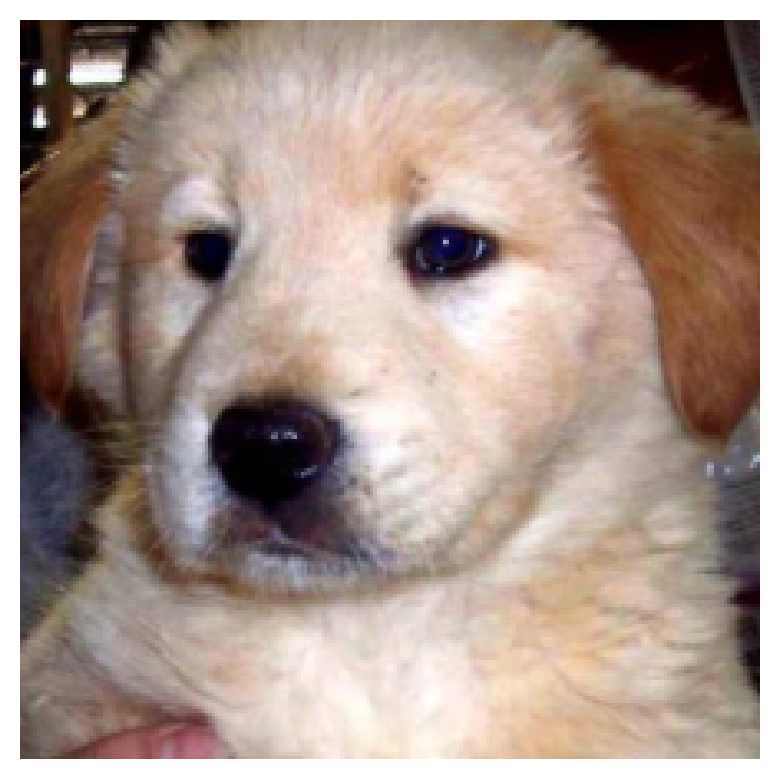

In [17]:
# Запустите код, чтобы протестировать загрузчик данных
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)
plt.show()

Если вы правильно загрузили данные, вы должны увидеть что-то похожее на это (ваше изображение будет другим):

<img src='assets/cat_cropped.png' width=244>

## Аугментация данных (Data augmentation)

Общая стратегия для обучения нейронных сетей - это введение случайности в сами входные данные. Например, вы можете случайным образом вращать, зеркалить, масштабировать и/или обрезать ваши изображения во время обучения. Это поможет вашей сети обобщать, поскольку она видит одни и те же изображения, но в разных местах, с разными размерами и в разных ориентациях и т. д.

Чтобы случайным образом вращать, масштабировать, обрезать, а затем переворачивать ваши изображения, вы должны определить свои преобразования следующим образом:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

Вы также, как правило, хотите нормализовать изображения с помощью `transforms.Normalize`. Вы передаете список средних значений и стандартных отклонений, а затем цветовые каналы нормализуются следующим образом

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Вычитание `mean` центрирует данные около нуля, а деление на `std` приводит значения к диапазону от -1 до 1. Нормализация помогает поддерживать веса сети ближе к нулю, что, в свою очередь, делает обратное распространение более стабильным. Без нормализации обучение сети может не быть успешным.

Вы можете найти список всех [доступных преобразований здесь](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). Когда вы тестируете, вы обычно хотите использовать изображения без применения преобразований, за исключением нормализации. Таким образом, для валидационных/тестовых изображений обычно просто изменяется размер и проводится обрезание.

>**Упражнение:** Определите преобразования для обучающих и тестовых данных. Пока что не используйте нормализацию.

In [33]:
## TODO

data_dir = 'Cat_Dog_data'

# TODO: Определите преобразования для обучающих и тестовых данных
train_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.RandomRotation(45),
                                        transforms.RandomResizedCrop(124),
                                        transforms.RandomHorizontalFlip(0.5),
                                        transforms.ToTensor()
                                       ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(124),
                                        transforms.ToTensor()
                                       ])


# Передайте преобразования сюда, затем выполните следующую ячейку, чтобы увидеть, как выглядят преобразования
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

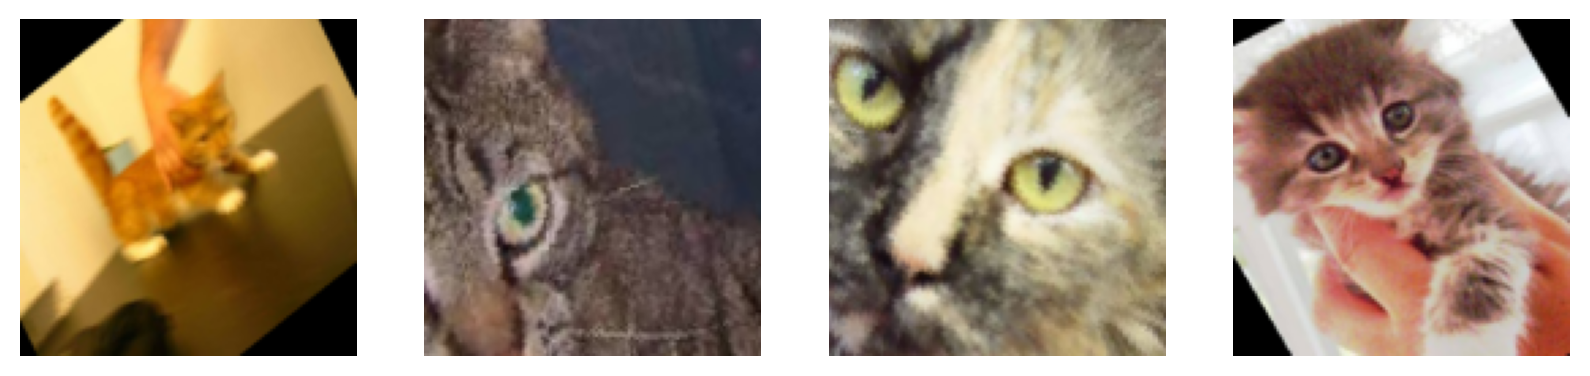

In [34]:
# измените переменную на trainloader или testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

plt.show()

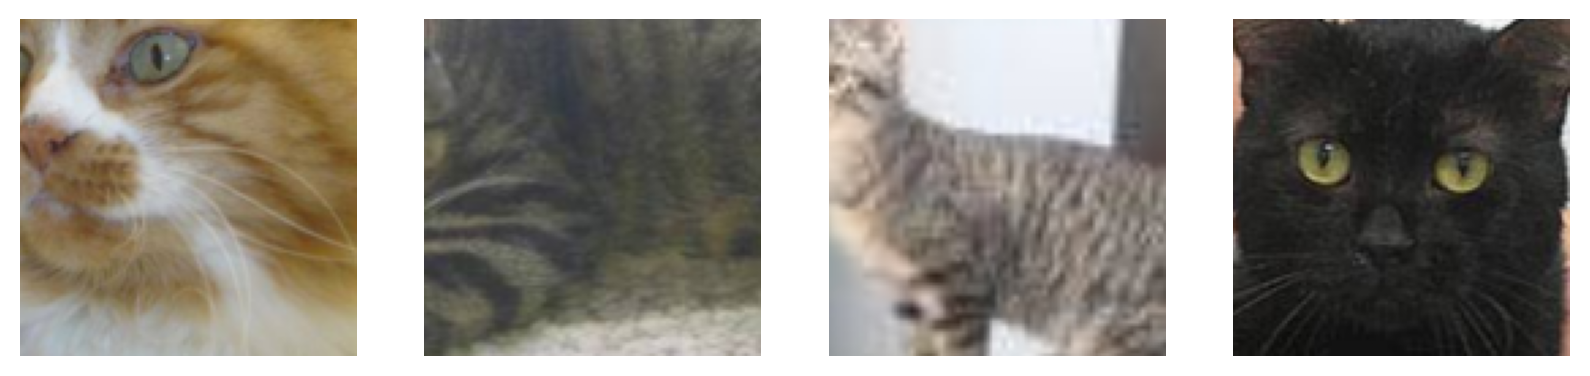

In [35]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

plt.show()

Ваши преобразованные изображения должны выглядеть примерно так.

<center>Обучающие примеры:</center>
<img src='assets/train_examples.png' width=500px>

<center>Тестовые примеры:</center>
<img src='assets/test_examples.png' width=500px>